In [1]:
%reload_ext autoreload
%autoreload 2
import sys
sys.path.append('/home/sebastian/masters/') # add my repo to python path
import os
import torch
import torch.nn.functional as F
import torch_geometric
import kmbio  # fork of biopython PDB with some changes in how the structure, chain, etc. classes are defined.
import numpy as np
import pandas as pd
import proteinsolver
import modules

from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, BatchSampler
from sklearn.model_selection import KFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import *
from torch import nn, optim
from pathlib import Path

from modules.dataset_utils import *
from modules.dataset import *
from modules.utils import *
from modules.models import *
from modules.lstm_utils import *

np.random.seed(0)
torch.manual_seed(0)

### Paths

In [2]:
root = Path("/home/sebastian/masters/data/")
data_root = root / "neat_data"
metadata_path = data_root / "metadata.csv"
processed_dir = data_root / "processed" / "tcr_binding"
state_file = root / "state_files" / "e53-s1952148-d93703104.state"
out_dir = root / "state_files" / "tcr_binding"

### Get metadata

In [3]:
model_dir = data_root / "raw" / "tcrpmhc"

paths = list(model_dir.glob("*"))
join_key = [int(x.name.split("_")[0]) for x in paths]
path_df = pd.DataFrame({'#ID': join_key, 'path': paths})

metadata = pd.read_csv(metadata_path)
metadata = metadata.join(path_df.set_index("#ID"), on="#ID", how="inner")  # filter to non-missing data
metadata = metadata.reset_index(drop=True)
metadata

,#ID,CDR3a,CDR3b,peptide,partition,binder,v_gene_alpha,j_gene_alpha,v_gene_beta,j_gene_beta,origin,v_alpha_vdjdb_name,j_alpha_vdjdb_name,v_beta_vdjdb_name,j_beta_vdjdb_name,path
0,1,AVSQSNTGKLI,ASSQLMENTEAF,NLVPMVATV,1,0,TRAV12-2,TRAJ37,TRBV4-1,TRBJ1-1,tenX,TRAV12-2*01,TRAJ37*01,TRBV4-1*01,TRBJ1-1*01,/home/sebastian/masters/data/neat_data/raw/tcr...
1,2,AASEVCADYKLS,ASSYSLLRAAPNTEAF,NLVPMVATV,1,0,TRAV29DV5,TRAJ20,TRBV6-3,TRBJ1-1,tenX,TRAV29/DV5*01,TRAJ20*01,TRBV6-3*01,TRBJ1-1*01,/home/sebastian/masters/data/neat_data/raw/tcr...
2,3,AGRLGAQKLV,ASSQGGRRNQPQH,NLVPMVATV,1,0,TRAV25,TRAJ54,TRBV4-2,TRBJ1-5,tenX,TRAV25*01,TRAJ54*01,TRBV4-2*01,TRBJ1-5*01,/home/sebastian/masters/data/neat_data/raw/tcr...
3,4,AVEPLYGNKLV,ASSSREAEAF,NLVPMVATV,1,0,TRAV22,TRAJ47,TRBV7-9,TRBJ1-1,tenX,TRAV22*01,TRAJ47*01,TRBV7-9*01,TRBJ1-1*01,/home/sebastian/masters/data/neat_data/raw/tcr...
4,5,ASGTYKYI,ASSQRAGRVDTQY,NLVPMVATV,1,0,TRAV19,TRAJ40,TRBV27,TRBJ2-3,tenX,TRAV19*01,TRAJ40*01,TRBV27*01,TRBJ2-3*01,/home/sebastian/masters/data/neat_data/raw/tcr...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10326,12961,AVNSYYNQGGKLI,SVLQGSPYEQY,GILGFVFTL,1,1,TRAV12-2*01,TRAJ23*01,TRBV29-1*01,TRBJ2-7*01,positive,TRAV12-2*01,TRAJ23*01,TRBV29-1*01,TRBJ2-7*01,/home/sebastian/masters/data/neat_data/raw/tcr...
10327,12962,AGNYGGSQGNLI,ASSIYSVNEQF,GILGFVFTL,1,1,TRAV35*01,TRAJ42*01,TRBV19*01,TRBJ2-1*01,positive,TRAV35*01,TRAJ42*01,TRBV19*01,TRBJ2-1*01,/home/sebastian/masters/data/neat_data/raw/tcr...
10328,12966,AVGGSQGNLI,ASSVRSSYEQY,GILGFVFTL,1,1,TRAV8-6*02,TRAJ42*01,TRBV19*01,TRBJ2-7*01,positive,TRAV8-6*01,TRAJ42*01,TRBV19*01,TRBJ2-7*01,/home/sebastian/masters/data/neat_data/raw/tcr...
10329,12968,AENGGGGADGLT,ASSIRSSYEQY,GILGFVFTL,1,1,TRAV13-2*01,TRAJ45*01,TRBV19*01,TRBJ2-7*01,positive,TRAV13-2*01,TRAJ45*01,TRBV19*01,TRBJ2-7*01,/home/sebastian/masters/data/neat_data/raw/tcr...


i = 10326
print(metadata.iloc[i])
print(metadata.iloc[i]["path"])

print(torch.load(f"/home/sebastian/masters/data/neat_data/processed/tcr_binding/data_{i}.pt"))
print(torch.load(f"/home/sebastian/masters/data/neat_data/processed/tcr_binding/data_{i}.pt").y)

print(torch.load(f"/home/sebastian/masters/data/neat_data/processed/tcr_binding/gnn_out_pos_128/data_{i}.pt").shape)
print(targets[i])
print(raw_files[i])
print(dataset[i][0].shape, dataset[i][1])

### Make GNN embeddings

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# init proteinsolver gnn
num_features = 20
adj_input_size = 2
hidden_size = 128

gnn = Net(
    x_input_size=num_features + 1, 
    adj_input_size=adj_input_size, 
    hidden_size=hidden_size, 
    output_size=num_features
)
gnn.load_state_dict(torch.load(state_file, map_location=device))
gnn.eval()
gnn = gnn.to(device)

raw_files = np.array(metadata["path"])
targets = np.array(metadata["binder"])

dataset = ProteinDataset(processed_dir, raw_files, targets, overwrite=False)

gnn_func = gnn.forward_without_last_layer
out_dir = processed_dir / "gnn_out_pos_128"
#create_gnn_embeddings(dataset, out_dir, device, gnn_func, cores=4, overwrite=False)
#create_gnn_embeddings(dataset, out_dir, device, gnn_func, overwrite=False)

### Make LOO partitions and init dataset

In [6]:
loo_train_partitions, loo_valid_partitions, unique_peptides = generate_loo_partitions(metadata)

dataset = LSTMDataset(
    data_dir=processed_dir / "gnn_out_pos_128", 
    annotations_path=processed_dir / "gnn_out_pos_128" / "targets.pt"
)

In [7]:
for x in [(len(x), len(y), len(x)+len(y)) for x,y in zip(loo_train_partitions, loo_valid_partitions)]:
    print(x)

(8381, 1217, 9598)
(10214, 70, 10284)
(10174, 87, 10261)
(10017, 201, 10218)
(10253, 39, 10292)
(10236, 54, 10290)
(10182, 89, 10271)
(10169, 86, 10255)
(9946, 217, 10163)
(10262, 34, 10296)
(9917, 245, 10162)
(7613, 1667, 9280)
(10192, 76, 10268)
(2011, 6223, 8234)
(10306, 8, 10314)
(10308, 7, 10315)


### LOO training scheme

In [9]:
# LSTM params
batch_size = 8
embedding_dim = 128
hidden_dim = 32 #32
num_layers = 2  # from 2
epochs = 10
learning_rate = 1e-3
lr_decay = 0.95
w_decay = 1e-4
dropout = 0.8  # test scheduled dropout. Can set droput using net.layer.dropout = 0.x https://arxiv.org/pdf/1703.06229.pdf

# touch files to ensure output
n_splits = len(unique_peptides)
save_dir = get_non_dupe_dir(out_dir)
loss_paths = touch_output_files(save_dir, "loss", n_splits)
state_paths = touch_output_files(save_dir, "state", n_splits)
pred_paths = touch_output_files(save_dir, "pred", n_splits)

extra_print_str = "\nSaving to {}\nFold: {}\nPeptide: {}"

i = 0
for train_idx, valid_idx in zip(loo_train_partitions, loo_valid_partitions):
    
    net = QuadLSTM(
        embedding_dim=embedding_dim, 
        hidden_dim=hidden_dim, 
        num_layers=num_layers, 
        dropout=dropout,
    )
    net = net.to(device)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(
        net.parameters(), 
        lr=learning_rate, 
        #weight_decay=w_decay,
    )  # test learning rate scheduler to reduce validation volatility
    scheduler = optim.lr_scheduler.MultiplicativeLR(
        optimizer, 
        lr_lambda=lambda epoch: lr_decay
    )
    
    net, train_losses, valid_losses = lstm_quad_train(
        net,
        epochs,
        criterion,
        optimizer,
        scheduler,
        dataset,
        train_idx,
        valid_idx,
        batch_size,
        device,
        extra_print=extra_print_str.format(save_dir, i, unique_peptides[i]),
    )
    torch.save(net.state_dict(), state_paths[i])
    torch.save({"train": train_losses, "valid": valid_losses}, loss_paths[i])
    
    pred, true = lstm_quad_predict(net, dataset, valid_idx, device)     
    torch.save({"y_pred": pred, "y_true": true}, pred_paths[i])
    
    i += 1


Saving to /home/sebastian/masters/data/neat_data/processed/tcr_binding/gnn_out_pos_128/36304b17bb53777cb56950e17e73ad3d
Fold: 0
Peptide: NLVPMVATV

epoch: 1 - n: 25/1048 - [2%                                                           ]


KeyboardInterrupt: 

In [12]:
from io import StringIO 
import sys

class Capturing(list):
    def __enter__(self):
        self._stdout = sys.stdout
        sys.stdout = self._stringio = StringIO()
        return self
    def __exit__(self, *args):
        self.extend(self._stringio.getvalue().splitlines())
        del self._stringio    # free up some memory
        sys.stdout = self._stdout

with Capturing() as output:
    for _ in train_loader:
        pass

In [68]:
err_f = open("/home/sebastian/masters/data/train_run.log", "r")
lines = err_f.readlines()
lines = [line.strip() for line in lines]
data = dict()
prev_i = str()
prev_mode = str()
for line in lines:
    if line[0] == ">":
        if line != ">train" and line != ">pred" and line != ">valid":
            prev_i = line[1:]
            data[prev_i] = dict()
        else:
            prev_mode = line[1:]
            data[prev_i][prev_mode] = list()
    else:
        try:
            data[prev_i][prev_mode].append(int(line))
        except ValueError as err:
            print(err)

### Performance metrics

In [12]:
import matplotlib.pyplot as plt
import copy

#save_dir = Path("/home/sebastian/masters/data/state_files/tcr_binding/computerome/tcr_binding/batch_norm_in/621f7c26a4efaf043d39d0e78402f4b0")
save_dir = Path("/home/sebastian/masters/data/state_files/tcr_binding/archive/filter_cdr3b_and_cdr3a/50f2df244c395d50d6d8712860e754a3")
#save_dir = Path("//home/sebastian/masters/data/state_files/tcr_binding/computerome/tcr_binding/2nd_gen/more_reg/799deb1e8008d82d5e4fb5938fb2472c")
#save_dir = Path("/home/sebastian/masters/data/state_files/tcr_binding/computerome/tcr_binding/2nd_gen/cdr3_pep/750a4e18eea59e6d2cc356bccb8ed97f")
pred_paths = [save_dir / f"pred_{i}.pt" for i in range(len(unique_peptides))]

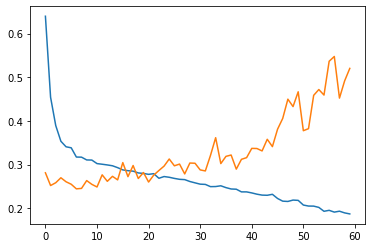

In [13]:
t = torch.load(save_dir/"loss_1.pt")
plt.plot(t["train"])
plt.plot(t["valid"])

0.6235389487972249 0.12917573178136746
0.4492307692307692 -0.11322770341445958
0.7691387559808612 0.24864232687667556
0.5415601023017902 0.007104777058198859
0.5555555555555556 0.12535663410560174
0.3202614379084967 -0.07747516350666292
0.39814814814814814 -0.08539246441078678
0.4109090909090909 -0.12002285007042346
0.6028257456828885 -0.10133537070656029
0.6413793103448275 0.06206896551724138
0.5722480620155039 -0.010166571355506977
0.6202104312753729 0.013152556055830262
0.5472636815920398 -0.0021552975531433836
0.5123170858210532 -0.07356441837440734
1.0 0.6546536707079772
0.8333333333333334 0.47140452079103173
overall AUC: 0.5763807934766378
overall MCC (t=0.1): -0.02689443096559898


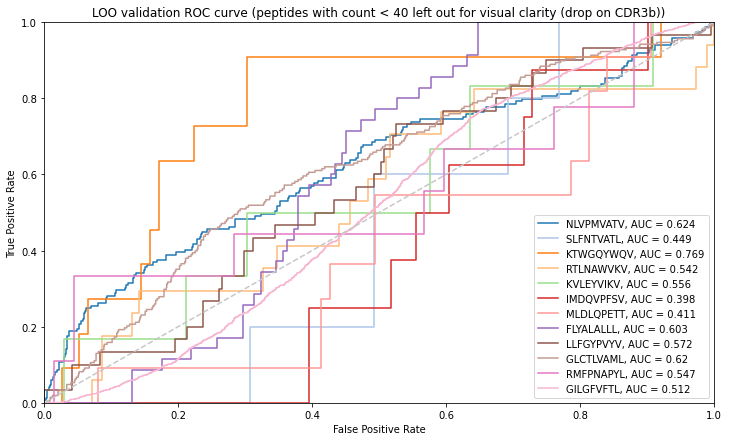

In [14]:
n_splits = len(unique_peptides)
threshold = 0.1

overall_pred = list()
overall_true = list()
overall_thres_pred = list()
# compute metrics
perf_data = dict()
for i in range(n_splits):
    data = torch.load(pred_paths[i])
    pred = data["y_pred"]
    true = data["y_true"]

    # auc
    auc = roc_auc_score(true, pred)
    fpr, tpr, thr = roc_curve(true, pred, pos_label=1)
    
    thresh_pred = torch.zeros(len(pred))
    thresh_pred[pred >= threshold] = 1
    mcc = matthews_corrcoef(true, thresh_pred)
    
    pep = unique_peptides[i]
    perf_data[pep] = [fpr, tpr, auc, mcc]

    print(auc, mcc)

    overall_pred.extend(pred)
    overall_true.extend(true)
    overall_thres_pred.extend(thresh_pred)

print("overall AUC:", roc_auc_score(overall_true, overall_pred))  
print(f"overall MCC (t={threshold}):", matthews_corrcoef(overall_true, overall_thres_pred))

performance_file = save_dir / "performance_data.pt"
torch.save(perf_data, performance_file)

# ROC plot
cm = plt.get_cmap('tab20')  # https://matplotlib.org/stable/tutorials/colors/colormaps.html

fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111)
ax.set_prop_cycle(color=[cm(1*i/n_splits) for i in range(n_splits)])
excluded = ["KLQCVDLHV", "KVAELVHFL", "YLLEMLWRL", "SLLMWITQV"] # TODO delete (filter <40 in test set)
for pep in unique_peptides:
    if pep not in excluded:
        ax.plot(
            perf_data[pep][0], 
            perf_data[pep][1], 
            label=f"{pep}, AUC = {round(perf_data[pep][2], 3)}",
        )
plt.legend()
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("LOO validation ROC curve (peptides with count < 40 left out for visual clarity (drop on CDR3b))")
plt.show()

In [110]:
unique_peptides

array(['NLVPMVATV', 'SLFNTVATL', 'KTWGQYWQV', 'RTLNAWVKV', 'KVLEYVIKV',
       'YLLEMLWRL', 'IMDQVPFSV', 'MLDLQPETT', 'FLYALALLL', 'SLLMWITQV',
       'LLFGYPVYV', 'GLCTLVAML', 'RMFPNAPYL', 'GILGFVFTL', 'KLQCVDLHV',
       'KVAELVHFL'], dtype=object)

In [32]:
t = torch.load(save_dir/"pred_4.pt")

In [33]:
t["y_true"]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
        1., 1., 1.])

In [34]:
t["y_pred"]

tensor([0.0924, 0.0857, 0.0585, 0.0780, 0.0714, 0.0818, 0.0793, 0.0675, 0.0841,
        0.0609, 0.0865, 0.0782, 0.0917, 0.1131, 0.0727, 0.0775, 0.0738, 0.0766,
        0.1024, 0.0834, 0.0721, 0.1062, 0.0904, 0.1007, 0.0818, 0.0640, 0.0864,
        0.0657, 0.0683, 0.1127, 0.1022, 0.0599, 0.0631, 0.0540, 0.0789, 0.0702,
        0.0626, 0.0921, 0.0906])

In [18]:
pep_df = metadata[metadata["peptide"] == unique_peptides[4]]
pep_df = pep_df.reset_index()
pep_df

,index,#ID,CDR3a,CDR3b,peptide,partition,binder,v_gene_alpha,j_gene_alpha,v_gene_beta,j_gene_beta,origin,v_alpha_vdjdb_name,j_alpha_vdjdb_name,v_beta_vdjdb_name,j_beta_vdjdb_name,path,merged_chains
0,184,231,AVGGNNRLA,SARARGSNEQF,KVLEYVIKV,1,0,TRAV12-2,TRAJ7,TRBV20-1,TRBJ2-1,tenX,TRAV12-2*01,TRAJ7*01,TRBV20-1*01,TRBJ2-1*01,/home/sebastian/masters/data/neat_data/raw/tcr...,AVGGNNRLASARARGSNEQF
1,185,232,AEGGNTGKLI,ASSHLGGDRYMNEQF,KVLEYVIKV,1,0,TRAV5,TRAJ37,TRBV3-1,TRBJ2-1,tenX,TRAV5*01,TRAJ37*01,TRBV3-1*01,TRBJ2-1*01,/home/sebastian/masters/data/neat_data/raw/tcr...,AEGGNTGKLIASSHLGGDRYMNEQF
2,186,233,ATTHQGAQKLV,SARDFRGRETQY,KVLEYVIKV,1,0,TRAV17,TRAJ54,TRBV20-1,TRBJ2-5,tenX,TRAV17*01,TRAJ54*01,TRBV20-1*01,TRBJ2-5*01,/home/sebastian/masters/data/neat_data/raw/tcr...,ATTHQGAQKLVSARDFRGRETQY
3,187,234,AFIEDKII,ASSWSSAGGPSYEQY,KVLEYVIKV,1,0,TRAV24,TRAJ30,TRBV5-6,TRBJ2-7,tenX,TRAV24*01,TRAJ30*01,TRBV5-6*01,TRBJ2-7*01,/home/sebastian/masters/data/neat_data/raw/tcr...,AFIEDKIIASSWSSAGGPSYEQY
4,1517,1871,AESENTGGFKTI,ASIPRSGQGYEQY,KVLEYVIKV,2,0,TRAV5,TRAJ9,TRBV7-9,TRBJ2-7,tenX,TRAV5*01,TRAJ9*01,TRBV7-9*01,TRBJ2-7*01,/home/sebastian/masters/data/neat_data/raw/tcr...,AESENTGGFKTIASIPRSGQGYEQY
5,1518,1872,AVRDDGAGNNRKLI,ASSSGQGSSSYEQY,KVLEYVIKV,2,0,TRAV1-2,TRAJ38,TRBV7-9,TRBJ2-7,tenX,TRAV1-2*01,TRAJ38*01,TRBV7-9*01,TRBJ2-7*01,/home/sebastian/masters/data/neat_data/raw/tcr...,AVRDDGAGNNRKLIASSSGQGSSSYEQY
6,1519,1873,AETQDSNYQLI,ASSIRSSYEQY,KVLEYVIKV,2,0,TRAV5,TRAJ33,TRBV19,TRBJ2-7,tenX,TRAV5*01,TRAJ33*01,TRBV19*01,TRBJ2-7*01,/home/sebastian/masters/data/neat_data/raw/tcr...,AETQDSNYQLIASSIRSSYEQY
7,1520,1874,AMSINNAGNMLT,ASSSTNPYEQY,KVLEYVIKV,2,0,TRAV12-3,TRAJ39,TRBV10-2,TRBJ2-7,tenX,TRAV12-3*01,TRAJ39*01,TRBV10-2*01,TRBJ2-7*01,/home/sebastian/masters/data/neat_data/raw/tcr...,AMSINNAGNMLTASSSTNPYEQY
8,1521,1875,ALSEEYNFNKFY,ASSQEASRPRD,KVLEYVIKV,2,0,TRAV19,TRAJ21,TRBV3-1,TRBJ2-4,tenX,TRAV19*01,TRAJ21*01,TRBV3-1*01,TRBJ2-4*01,/home/sebastian/masters/data/neat_data/raw/tcr...,ALSEEYNFNKFYASSQEASRPRD
9,2844,3511,AFGKGFKTI,ASSEGSGGSYNEQF,KVLEYVIKV,3,0,TRAV24,TRAJ9,TRBV6-1,TRBJ2-1,tenX,TRAV24*01,TRAJ9*01,TRBV6-1*01,TRBJ2-1*01,/home/sebastian/masters/data/neat_data/raw/tcr...,AFGKGFKTIASSEGSGGSYNEQF


In [61]:
i=-7
metadata[metadata["CDR3a"] == pep_df.iloc[i]["CDR3a"]]

,#ID,CDR3a,CDR3b,peptide,partition,binder,v_gene_alpha,j_gene_alpha,v_gene_beta,j_gene_beta,origin,v_alpha_vdjdb_name,j_alpha_vdjdb_name,v_beta_vdjdb_name,j_beta_vdjdb_name,path,merged_chains
8426,10494,AASFIIQGAQKLV,ASSLLGGWSEAF,KVLEYVIKV,1,0,TRAV13-1*01,TRAJ54*01,TRBV27*01,TRBJ1-1*01,swapped,TRAV13-1*01,TRAJ54*01,TRBV27*01,TRBJ1-1*01,/home/sebastian/masters/data/neat_data/raw/tcr...,AASFIIQGAQKLVASSLLGGWSEAF
10236,12855,AASFIIQGAQKLV,ASSLLGGWSEAF,GILGFVFTL,1,1,TRAV13-1*01,TRAJ54*01,TRBV27*01,TRBJ1-1*01,positive,TRAV13-1*01,TRAJ54*01,TRBV27*01,TRBJ1-1*01,/home/sebastian/masters/data/neat_data/raw/tcr...,AASFIIQGAQKLVASSLLGGWSEAF


In [62]:
print(t["y_pred"][i], t["y_true"][i])

tensor(0.1656) tensor(0.)


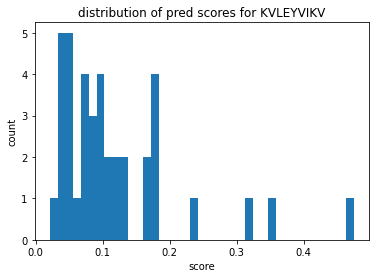

In [265]:
plt.hist(t["y_pred"], bins=len(t["y_pred"]))
plt.xlabel("score")
plt.ylabel("count")
plt.title("distribution of pred scores for KVLEYVIKV")
plt.show()

In [247]:
metadata[metadata["peptide"] == unique_peptides[4]]

,#ID,CDR3a,CDR3b,peptide,partition,binder,v_gene_alpha,j_gene_alpha,v_gene_beta,j_gene_beta,origin,v_alpha_vdjdb_name,j_alpha_vdjdb_name,v_beta_vdjdb_name,j_beta_vdjdb_name,path,merged_chains
184,231,AVGGNNRLA,SARARGSNEQF,KVLEYVIKV,1,0,TRAV12-2,TRAJ7,TRBV20-1,TRBJ2-1,tenX,TRAV12-2*01,TRAJ7*01,TRBV20-1*01,TRBJ2-1*01,/home/sebastian/masters/data/neat_data/raw/tcr...,AVGGNNRLASARARGSNEQF
185,232,AEGGNTGKLI,ASSHLGGDRYMNEQF,KVLEYVIKV,1,0,TRAV5,TRAJ37,TRBV3-1,TRBJ2-1,tenX,TRAV5*01,TRAJ37*01,TRBV3-1*01,TRBJ2-1*01,/home/sebastian/masters/data/neat_data/raw/tcr...,AEGGNTGKLIASSHLGGDRYMNEQF
186,233,ATTHQGAQKLV,SARDFRGRETQY,KVLEYVIKV,1,0,TRAV17,TRAJ54,TRBV20-1,TRBJ2-5,tenX,TRAV17*01,TRAJ54*01,TRBV20-1*01,TRBJ2-5*01,/home/sebastian/masters/data/neat_data/raw/tcr...,ATTHQGAQKLVSARDFRGRETQY
187,234,AFIEDKII,ASSWSSAGGPSYEQY,KVLEYVIKV,1,0,TRAV24,TRAJ30,TRBV5-6,TRBJ2-7,tenX,TRAV24*01,TRAJ30*01,TRBV5-6*01,TRBJ2-7*01,/home/sebastian/masters/data/neat_data/raw/tcr...,AFIEDKIIASSWSSAGGPSYEQY
1517,1871,AESENTGGFKTI,ASIPRSGQGYEQY,KVLEYVIKV,2,0,TRAV5,TRAJ9,TRBV7-9,TRBJ2-7,tenX,TRAV5*01,TRAJ9*01,TRBV7-9*01,TRBJ2-7*01,/home/sebastian/masters/data/neat_data/raw/tcr...,AESENTGGFKTIASIPRSGQGYEQY
1518,1872,AVRDDGAGNNRKLI,ASSSGQGSSSYEQY,KVLEYVIKV,2,0,TRAV1-2,TRAJ38,TRBV7-9,TRBJ2-7,tenX,TRAV1-2*01,TRAJ38*01,TRBV7-9*01,TRBJ2-7*01,/home/sebastian/masters/data/neat_data/raw/tcr...,AVRDDGAGNNRKLIASSSGQGSSSYEQY
1519,1873,AETQDSNYQLI,ASSIRSSYEQY,KVLEYVIKV,2,0,TRAV5,TRAJ33,TRBV19,TRBJ2-7,tenX,TRAV5*01,TRAJ33*01,TRBV19*01,TRBJ2-7*01,/home/sebastian/masters/data/neat_data/raw/tcr...,AETQDSNYQLIASSIRSSYEQY
1520,1874,AMSINNAGNMLT,ASSSTNPYEQY,KVLEYVIKV,2,0,TRAV12-3,TRAJ39,TRBV10-2,TRBJ2-7,tenX,TRAV12-3*01,TRAJ39*01,TRBV10-2*01,TRBJ2-7*01,/home/sebastian/masters/data/neat_data/raw/tcr...,AMSINNAGNMLTASSSTNPYEQY
1521,1875,ALSEEYNFNKFY,ASSQEASRPRD,KVLEYVIKV,2,0,TRAV19,TRAJ21,TRBV3-1,TRBJ2-4,tenX,TRAV19*01,TRAJ21*01,TRBV3-1*01,TRBJ2-4*01,/home/sebastian/masters/data/neat_data/raw/tcr...,ALSEEYNFNKFYASSQEASRPRD
2844,3511,AFGKGFKTI,ASSEGSGGSYNEQF,KVLEYVIKV,3,0,TRAV24,TRAJ9,TRBV6-1,TRBJ2-1,tenX,TRAV24*01,TRAJ9*01,TRBV6-1*01,TRBJ2-1*01,/home/sebastian/masters/data/neat_data/raw/tcr...,AFGKGFKTIASSEGSGGSYNEQF


In [60]:
fpr, tpr, thr = roc_curve(t["y_true"], t["y_pred"], drop_intermediate=False)

In [62]:
len(thr)

68

In [63]:
fpr

array([0.        , 0.01538462, 0.03076923, 0.04615385, 0.06153846,
       0.07692308, 0.09230769, 0.10769231, 0.12307692, 0.13846154,
       0.15384615, 0.16923077, 0.18461538, 0.2       , 0.21538462,
       0.23076923, 0.24615385, 0.26153846, 0.27692308, 0.27692308,
       0.30769231, 0.30769231, 0.33846154, 0.35384615, 0.36923077,
       0.38461538, 0.4       , 0.41538462, 0.43076923, 0.43076923,
       0.43076923, 0.44615385, 0.46153846, 0.47692308, 0.49230769,
       0.52307692, 0.53846154, 0.55384615, 0.55384615, 0.56923077,
       0.58461538, 0.6       , 0.61538462, 0.63076923, 0.64615385,
       0.66153846, 0.67692308, 0.69230769, 0.70769231, 0.72307692,
       0.73846154, 0.75384615, 0.76923077, 0.78461538, 0.8       ,
       0.81538462, 0.83076923, 0.84615385, 0.86153846, 0.87692308,
       0.89230769, 0.90769231, 0.92307692, 0.93846154, 0.95384615,
       0.96923077, 0.98461538, 1.        ])

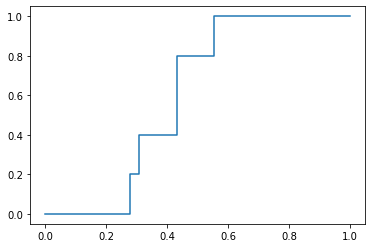

In [61]:
plt.plot(fpr, tpr)

In [ ]:
# confusion matrix
labels = ["non-binder", "binder"]
pred_copy = copy.deepcopy(pred)
pred_copy[pred >= 0.2] = 1
pred_copy[pred < 0.2] = 0
cm = confusion_matrix(true, pred_copy)

# f1
f1 = f1_score(true, pred_copy)
disp = ConfusionMatrixDisplay(cm, display_labels=labels)
plot = disp.plot()
plot.figure_.show()

In [ ]:
fold_idx = 1
data = torch.load(performance_file)[fold_idx]

cm, f1, auc = data["cm"], data["f1"], data["auc"]
disp = ConfusionMatrixDisplay(cm, display_labels=labels)
disp.plot()
print(f"LOO performance of fold {fold_idx}:")
print(f"AUC={auc}")
print(f"F1={f1}")

In [12]:
# quick viz
count_dict = dict()
for pep in unique_peptides:
    total = len(metadata[metadata["peptide"] == pep])
    pos = len(metadata[(metadata["peptide"] == pep) & (metadata["binder"] == 1)])
    count_dict[pep] = [total, pos]

In [13]:
count_dict

{'NLVPMVATV': [1217, 149],
 'SLFNTVATL': [70, 5],
 'KTWGQYWQV': [87, 11],
 'RTLNAWVKV': [201, 17],
 'KVLEYVIKV': [39, 6],
 'YLLEMLWRL': [54, 3],
 'IMDQVPFSV': [89, 8],
 'MLDLQPETT': [86, 11],
 'FLYALALLL': [217, 35],
 'SLLMWITQV': [34, 5],
 'LLFGYPVYV': [245, 30],
 'GLCTLVAML': [1667, 208],
 'RMFPNAPYL': [76, 9],
 'GILGFVFTL': [6223, 1311],
 'KLQCVDLHV': [8, 1],
 'KVAELVHFL': [7, 1]}

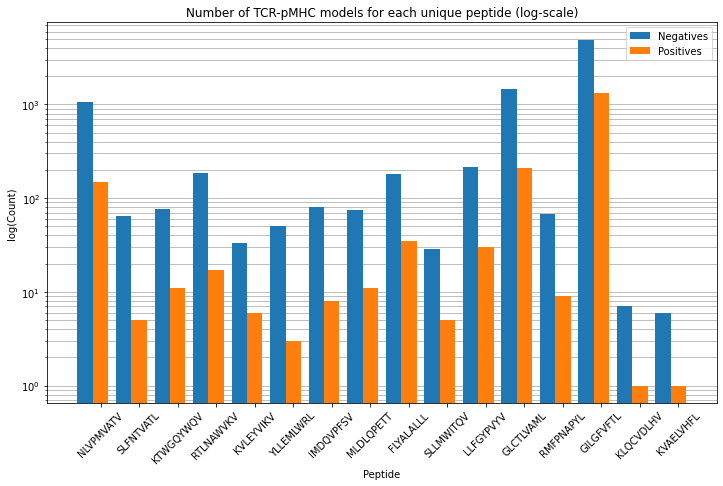

In [66]:
fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111)

peptides = list(count_dict.keys())
negatives = [x[0] - x[1] for x in count_dict.values()]
positives = [x[1] for x in count_dict.values()]

width = 0.4
idx = np.arange(len(unique_peptides))

ax.bar(idx, negatives, width, zorder=3)
ax.bar(idx + width, positives, width, zorder=3)
ax.set_yscale('log')
ax.set_xticks(idx+width)
ax.set_xticklabels(count_dict.keys(), rotation=45)

ax.grid(zorder=0, which='both', axis='y')

plt.legend(["Negatives", "Positives"])
plt.xlabel("Peptide")
plt.ylabel("log(Count)")
plt.title("Number of TCR-pMHC models for each unique peptide (log-scale)")
plt.show()